In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
from collections import Iterable
import json

from keras import Model, Input, Sequential, regularizers, losses, optimizers, regularizers, initializers
from keras.layers import Activation, Dense, LSTM, Embedding, Dropout, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, scale
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from scipy.optimize import golden, minimize, differential_evolution
from tsfresh.feature_selection.relevance import calculate_relevance_table
import boruta

%matplotlib inline

/opt/miniconda3/envs/research_trash/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda3/envs/research_trash/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.style.use(plt.style.library['dark_background'])
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

In [3]:
class SelectModel():
    def __init__(self, model, threshold=1e-5, max_features=None):
        self.model = model
        self.threshold = threshold
        self.max_features = max_features
    
    def fit(self, X, y):
        self.model.fit(X,y)
        if hasattr(self.model,'coef_'):
            scores = abs(self.model.coef_)
        else:
            scores = self.model.feature_importances_
        
        f = scores
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 
        
        scores = pd.Series(scores, X.columns)
        selected_features_ = scores[scores>1e-5].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [234]:
class SelectTsfresh():
    def __init__(self, fdr_level=0.05):
        self.fdr_level = fdr_level
    
    def fit(self, X, y):
        if y.ndim>1:
            print('WARNING: Tsfresh don\'t support multitarget. "y" should be a pd.Series')
            y = y.iloc[:,0]
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)
        
        relevance = calculate_relevance_table(X, y, fdr_level=self.fdr_level)
        relevance = relevance.reindex(X.columns)
        
        f = relevance['p_value'].dropna()
        f = 1-f
        f = f/f.sum()
        relevance['ranks'] = f
        relevance['ranks'].fillna(0, inplace=True)
        self.ranks_ = relevance['ranks']
        
        self.selected_features_ = relevance[relevance['relevant']==True]['feature'].values
        
        return self

In [5]:
class SelectFunction():
    def __init__(self, function, volume_info=0.97, max_features=None):
        self.function = function
        self.volume_info = volume_info
        self.max_features = max_features
    
    def fit(self, X, y):
        scores = self.function(X,y)
        if isinstance(scores, tuple):
            scores = scores[0]
        
        f = np.nan_to_num(scores)
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 

        for i in ranks_sort.index:
            summ = ranks_sort[:i].sum()
            if summ > self.volume_info:
                break
        selected_features_ = ranks_sort[:i].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [6]:
class SelectBoruta():
    def __init__(self, boruta, only_confirmed=True, prefit=False):
        self.prefit = prefit
        self.core = boruta
        self.only_confirmed = only_confirmed
    
    def fit(self, X, y):
        if not self.prefit:
            self.core.fit(np.array(X), np.array(y))
        
        f = self.core.ranking_
        f = f.sum()/f
        f = f/f.sum()
        
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        if self.only_confirmed:
            z = zip(X.columns, self.core.support_, np.zeros(X.shape[1]))
        else:
            z = zip(X.columns, self.core.support_, self.core.support_weak_)
            
        selected_features_ = []
        for i in z:
            if i[1] or i[2]:
                selected_features_.append(i[0])
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [175]:
def mass_fit(X, y, models, metric=mean_squared_error, scalerY=None, seed=None, verbose=True):
    if not isinstance(models, Iterable):
        models = (models,)
    
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    if verbose:
        print(f'train on {len(trainY)}, test on {len(testY)} rows x {len(trainX.columns)} columns')
    
    total = []

    for model in models:
        if seed is not None:
            np.random.seed(seed)
        
        cls = model.__class__
        
        model.fit(trainX, trainY)
        preds = model.predict(testX)
        
        if scalerY is not None:
            preds = scalerY.inverse_transform(np.array(preds).reshape(-1,1))
            _testY = scalerY.inverse_transform(np.array(testY).reshape(-1,1))
        else:
            _testY = testY
            
        result = metric(_testY, preds)
            
        if verbose:
            print(f'{cls.__name__:21} {result:.6f}')

        total.append({'result':result, 'core':model})
        
    np.random.seed()
    return total

In [342]:
class SelectEnsemble:
    def __init__(self, X, y, scalerY=None):
        self.X = X
        self.y = y
        self.scalerY = scalerY
        self.raw_score = None
    
    @staticmethod
    def _xgb_gen():
#         for i in np.linspace(0.1, 0.5, 5):
#             yield XGBRegressor(6, i,  n_estimators=20)
#         for i in [2,3,5,7]:
#             yield XGBRegressor(i, 0.1,  n_estimators=30)
        yield RandomForestRegressor(50)

    def _calc_raw_score(self):
        print('Raw data...')
        raw_score = mass_fit(self.X, self.y, self._xgb_gen(), scalerY=self.scalerY)
        raw_score = np.array([a['result'] for a in raw_score]).min()
        print('Raw score:', raw_score, '\n')
        self.raw_score = raw_score
        
    def select_features(self, a):
        ranks_sort = self.FI.sort_values(ascending=False)
        ranks_sort = ranks_sort/ranks_sort.sum()

        for i in ranks_sort.index:
            summ = ranks_sort[:i].sum()
            if summ > a:
                break
        selected_features = ranks_sort[:i].index

        res = pd.DataFrame(
            mass_fit(self.X[selected_features], self.y, self._xgb_gen(), scalerY=self.scalerY, verbose=True)
        )['result'].min()
        
        self.selected_features = selected_features
        
        print(a,':',len(selected_features),res)
        return selected_features

    def fit(self, methods, seed=None):
        if self.raw_score is None:
            self._calc_raw_score()
        
        results = []
        FI = []

        if not isinstance(methods, Iterable):
            methods = (methods,)

        for method in methods:
            print(method.__class__.__name__+'...')

            if seed is not None:
                np.random.seed(seed)

            method.fit(self.X, self.y)

            selected_features = method.selected_features_

            test_score = mass_fit(self.X[selected_features], self.y, self._xgb_gen(), scalerY=self.scalerY)
            test_score = np.array([a['result'] for a in test_score]).min()

            ranks = method.ranks_
            quality = self.raw_score/test_score

            FI.append(ranks * quality) #  quality**alpha ?

            results.append([method, selected_features, test_score, quality, ranks])

            print('quality:', quality)
            print('features selected:', len(selected_features), '\n')

        FI = np.array(FI).sum(0)
        FI = pd.Series(FI, index=X.columns)

        results = pd.DataFrame(results, columns=['core', 'selected_features', 'test_score', 'quality', 'ranks'])
        
        self.FI = FI
        self.results = results
        
        np.random.seed()
        
        return results, FI

In [185]:
class LightNN:
    def __init__(self, epochs, batch_size, neurons=200, lr=0.001, loss='mse', activation='tanh', validation_data=None, verbose=1):
        self.epochs = epochs
        self.batch_size = batch_size
        self.neurons = neurons
        self.lr = lr
        self.loss = loss
        self.activation = activation

        self.full_hist_loss = []
        self.full_hist_val = []

        self._verbose = verbose
        self._validation_data = validation_data


    def _build(self, X, y):
        n_feats = X.shape[1]
        size = X.shape[0]

        inputs = Input((n_feats,))
        x = Dense(self.neurons, activation=self.activation)(inputs)
        x = Dropout(0.5)(x)
        x = Dense(np.array(y).reshape((size, -1)).shape[1])(x)
        neural = Model(inputs=inputs, outputs=x)

        neural.compile(optimizer=optimizers.Adam(lr=self.lr, decay=0.), loss=self.loss, metrics=['mse'])

        self.model = neural


    def fit(self, X=None, y=None):
        self._build(X, y)

        self.model.fit(X, y, shuffle=False, verbose=self._verbose,
                       epochs=self.epochs, batch_size=self.batch_size, validation_data=self._validation_data,
                       callbacks=[
                           ModelCheckpoint('tmp_model.hdf5', monitor='val_mean_squared_error', save_best_only=True, save_weights_only=True)
                       ]
                      )
                               

        self.full_hist_loss += self.model.history.history['mean_squared_error']
        self.full_hist_val += self.model.history.history['val_mean_squared_error']
        
        if min(self.model.history.history['val_mean_squared_error']) != self.model.history.history['val_mean_squared_error'][-1]:
            if (self._verbose>0):
                plt.plot(self.full_hist_loss)
                plt.plot(self.full_hist_val)
                plt.show()
                print('loading...')
            self.model.load_weights('tmp_model.hdf5')

        return self


    def predict(self, X):
        preds = self.model.predict(X, len(X))
        return preds

In [159]:
def train_test_split(x,y,test_size=None, shuffle=False):
    """x_train, x_test, y_train, y_test"""
    x_train = x[::2]
    y_train = y[::2]
    x_test = x[1::2]
    y_test = y[1::2]
    return x_train, x_test, y_train, y_test

## Start

In [303]:
dataset = pd.read_hdf('/data_1/evraz/preprocessed_data_old__plus_new_19-10-18.h5', 'table')
dataset = dataset[dataset['__new_data'] == 1]
dataset.drop(labels=['DateTime','__DateTime'], axis=1, inplace=True)

In [304]:
dataset['AD'][dataset['AD'] == -1.] = np.nan
dataset['WT'][dataset['WT'] == -1.] = np.nan

/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [305]:
dataset['AD+1'] = dataset['AD'].shift(1).fillna(method='ffill')

In [306]:
dataset['WT+1'] = dataset['WT'].shift(1).fillna(method='ffill')

In [307]:
dataset = dataset.dropna()

In [308]:
dataset[dataset==-99] = np.nan

In [309]:
dataset.fillna(method='bfill', inplace=True)

In [310]:
stds = dataset.std()
useless = stds[(stds<1e-4)]

dataset.drop(useless.index, axis=1, inplace=True)

In [311]:
ad_feats = ['AD', 'AD_1m-mean', 'AD_1m-mean_shift_1', 'AD_interval_0_mean', 'AD_interval_0_mean_shift_1', 
            'AD_interval_1_mean', 'AD_interval_1_mean_shift_1', 'AD_interval_2_mean', 'AD_interval_2_mean_shift_1', 
            'AD_interval_3_mean', 'AD_interval_3_mean_shift_1', 'AD_interval_4_mean', 'AD_interval_4_mean_shift_1', 
            'AD_interval_5_mean', 'AD_interval_5_mean_shift_1', 'AD_interval_6_mean', 'AD_interval_6_mean_shift_1', 
            'AD_interval_7_mean', 'AD_interval_7_mean_shift_1', 'AD_shift_1']

wt_feats = ['WT', 'WT_1m-mean', 'WT_1m-mean_shift_1', 'WT_interval_0_mean', 'WT_interval_0_mean_shift_1', 'WT_interval_1_mean', 
            'WT_interval_1_mean_shift_1', 'WT_interval_2_mean', 'WT_interval_2_mean_shift_1', 'WT_interval_3_mean', 
            'WT_interval_3_mean_shift_1', 'WT_interval_4_mean', 'WT_interval_4_mean_shift_1', 'WT_interval_5_mean', 
            'WT_interval_5_mean_shift_1', 'WT_interval_6_mean', 'WT_interval_6_mean_shift_1', 'WT_interval_7_mean', 
            'WT_interval_7_mean_shift_1', 'WT_shift_1']

ratio_feats = ['Ratio', 'Ratio_1m-mean', 'Ratio_1m-mean_shift_1', 'Ratio_interval_0_mean', 'Ratio_interval_0_mean_shift_1', 
               'Ratio_interval_1_mean', 'Ratio_interval_1_mean_shift_1', 'Ratio_interval_2_mean', 
               'Ratio_interval_2_mean_shift_1', 'Ratio_interval_3_mean', 'Ratio_interval_3_mean_shift_1', 
               'Ratio_interval_4_mean', 'Ratio_interval_4_mean_shift_1', 'Ratio_interval_5_mean', 
               'Ratio_interval_5_mean_shift_1', 'Ratio_interval_6_mean', 'Ratio_interval_6_mean_shift_1', 
               'Ratio_interval_7_mean', 'Ratio_interval_7_mean_shift_1', 'Ratio_mean_15', 'Ratio_mean_15_shift_1', 
               'Ratio_mean_60', 'Ratio_mean_60_shift_1', 'Ratio_mean_by___AD_main_points', 
               'Ratio_mean_by___AD_main_points_shift_1', 'Ratio_shift_1']
               
tech_feats = ['TEST', 'TEST2', 'DateTime', 'DateTime_isin', 'DateTime_isin_AD', 'DateTime_isin_WT', 'pred_1', '_idx', '__DateTime']

feats_all = [i for i in dataset.columns if i not in ad_feats + wt_feats + ratio_feats + tech_feats and 'hl' not in i]
# feats_all += ['AD_shift_1', 'WT_shift_1']

In [312]:
scalerX = None
scalerY_AD = None
scalerY_WT = None

In [314]:
X = dataset[feats_all]

In [315]:
Y_AD = dataset[['AD']]
Y_WT = dataset[['WT']]

In [ ]:
# Standard Scaler

In [212]:
# scalerX = StandardScaler()
# X = pd.DataFrame(scalerX.fit_transform(X), X.index, columns=X.columns)

In [213]:
# scalerY_AD = StandardScaler()
# scalerY_WT = StandardScaler()

# Y_AD = scalerY_AD.fit_transform(Y_AD).ravel()
# Y_WT = scalerY_WT.fit_transform(Y_WT).ravel()

In [ ]:
# MinMax Scaler

In [219]:
# scalerX = MinMaxScaler()
# X = pd.DataFrame(scalerX.fit_transform(X), X.index, columns=X.columns)

In [220]:
# scalerY_AD = MinMaxScaler()
# scalerY_WT = MinMaxScaler()

# Y_AD = scalerY_AD.fit_transform(Y_AD).ravel()
# Y_WT = scalerY_WT.fit_transform(Y_WT).ravel()

In [370]:
Y_AD = np.array(Y_AD).ravel()
Y_WT = np.array(Y_WT).ravel()

## dummy

In [156]:
print('dummy AD:',mean_squared_error(dataset['AD'],dataset['AD+1']))
print('dummy WT:',mean_squared_error(dataset['WT'],dataset['WT+1']))

dummy AD: 2.251417910447761
dummy WT: 4.320149253731343


In [210]:
# mass_fit(X,Y_AD, LightNN(350,1000,activation='sigmoid',validation_data=train_test_split(X, Y_AD)[1::2]), scalerY=scalerY_AD)

train on 201, test on 201 rows x 4310 columns
Train on 201 samples, validate on 201 samples
Epoch 1/350
201/201 [==============================] - 2s 12ms/step - loss: 112.9507 - mean_squared_error: 112.9507 - val_loss: 51.7956 - val_mean_squared_error: 51.7956
Epoch 2/350
201/201 [==============================] - 0s 164us/step - loss: 52.9341 - mean_squared_error: 52.9341 - val_loss: 47.5998 - val_mean_squared_error: 47.5998
Epoch 3/350
201/201 [==============================] - 0s 194us/step - loss: 51.5145 - mean_squared_error: 51.5145 - val_loss: 45.0649 - val_mean_squared_error: 45.0649
Epoch 4/350
201/201 [==============================] - 0s 171us/step - loss: 47.0561 - mean_squared_error: 47.0561 - val_loss: 42.0899 - val_mean_squared_error: 42.0899
Epoch 5/350
201/201 [==============================] - 0s 180us/step - loss: 44.3010 - mean_squared_error: 44.3010 - val_loss: 40.7810 - val_mean_squared_error: 40.7810
Epoch 6/350
201/201 [==============================] - 0s 211u

Epoch 49/350
201/201 [==============================] - 0s 203us/step - loss: 9.5442 - mean_squared_error: 9.5442 - val_loss: 7.5835 - val_mean_squared_error: 7.5835
Epoch 50/350
201/201 [==============================] - 0s 193us/step - loss: 9.0163 - mean_squared_error: 9.0163 - val_loss: 7.3445 - val_mean_squared_error: 7.3445
Epoch 51/350
201/201 [==============================] - 0s 172us/step - loss: 8.8700 - mean_squared_error: 8.8700 - val_loss: 7.1186 - val_mean_squared_error: 7.1186
Epoch 52/350
201/201 [==============================] - 0s 170us/step - loss: 8.3616 - mean_squared_error: 8.3616 - val_loss: 6.9057 - val_mean_squared_error: 6.9057
Epoch 53/350
201/201 [==============================] - 0s 195us/step - loss: 9.4332 - mean_squared_error: 9.4332 - val_loss: 6.7044 - val_mean_squared_error: 6.7044
Epoch 54/350
201/201 [==============================] - 0s 184us/step - loss: 8.6494 - mean_squared_error: 8.6494 - val_loss: 6.5152 - val_mean_squared_error: 6.5152
Epoc

Epoch 99/350
201/201 [==============================] - 0s 163us/step - loss: 5.7358 - mean_squared_error: 5.7358 - val_loss: 4.0843 - val_mean_squared_error: 4.0843
Epoch 100/350
201/201 [==============================] - 0s 201us/step - loss: 5.7732 - mean_squared_error: 5.7732 - val_loss: 4.0804 - val_mean_squared_error: 4.0804
Epoch 101/350
201/201 [==============================] - 0s 174us/step - loss: 6.2407 - mean_squared_error: 6.2407 - val_loss: 4.0768 - val_mean_squared_error: 4.0768
Epoch 102/350
201/201 [==============================] - 0s 173us/step - loss: 6.1451 - mean_squared_error: 6.1451 - val_loss: 4.0737 - val_mean_squared_error: 4.0737
Epoch 103/350
201/201 [==============================] - 0s 187us/step - loss: 6.0285 - mean_squared_error: 6.0285 - val_loss: 4.0709 - val_mean_squared_error: 4.0709
Epoch 104/350
201/201 [==============================] - 0s 207us/step - loss: 5.9732 - mean_squared_error: 5.9732 - val_loss: 4.0685 - val_mean_squared_error: 4.0685

201/201 [==============================] - 0s 181us/step - loss: 5.9685 - mean_squared_error: 5.9685 - val_loss: 4.0470 - val_mean_squared_error: 4.0470
Epoch 149/350
201/201 [==============================] - 0s 195us/step - loss: 5.8485 - mean_squared_error: 5.8485 - val_loss: 4.0470 - val_mean_squared_error: 4.0470
Epoch 150/350
201/201 [==============================] - 0s 190us/step - loss: 5.4458 - mean_squared_error: 5.4458 - val_loss: 4.0472 - val_mean_squared_error: 4.0472
Epoch 151/350
201/201 [==============================] - 0s 179us/step - loss: 6.8143 - mean_squared_error: 6.8143 - val_loss: 4.0472 - val_mean_squared_error: 4.0472
Epoch 152/350
201/201 [==============================] - 0s 178us/step - loss: 7.2349 - mean_squared_error: 7.2349 - val_loss: 4.0473 - val_mean_squared_error: 4.0473
Epoch 153/350
201/201 [==============================] - 0s 176us/step - loss: 5.4425 - mean_squared_error: 5.4425 - val_loss: 4.0473 - val_mean_squared_error: 4.0473
Epoch 154/35

Epoch 198/350
201/201 [==============================] - 0s 177us/step - loss: 6.6037 - mean_squared_error: 6.6037 - val_loss: 4.0460 - val_mean_squared_error: 4.0460
Epoch 199/350
201/201 [==============================] - 0s 181us/step - loss: 6.2786 - mean_squared_error: 6.2786 - val_loss: 4.0459 - val_mean_squared_error: 4.0459
Epoch 200/350
201/201 [==============================] - 0s 172us/step - loss: 6.3150 - mean_squared_error: 6.3150 - val_loss: 4.0457 - val_mean_squared_error: 4.0457
Epoch 201/350
201/201 [==============================] - 0s 182us/step - loss: 6.3034 - mean_squared_error: 6.3034 - val_loss: 4.0456 - val_mean_squared_error: 4.0456
Epoch 202/350
201/201 [==============================] - 0s 178us/step - loss: 5.7920 - mean_squared_error: 5.7920 - val_loss: 4.0454 - val_mean_squared_error: 4.0454
Epoch 203/350
201/201 [==============================] - 0s 174us/step - loss: 5.8068 - mean_squared_error: 5.8068 - val_loss: 4.0452 - val_mean_squared_error: 4.045

201/201 [==============================] - 0s 159us/step - loss: 5.9580 - mean_squared_error: 5.9580 - val_loss: 4.0456 - val_mean_squared_error: 4.0456
Epoch 248/350
201/201 [==============================] - 0s 172us/step - loss: 6.1584 - mean_squared_error: 6.1584 - val_loss: 4.0457 - val_mean_squared_error: 4.0457
Epoch 249/350
201/201 [==============================] - 0s 173us/step - loss: 6.0825 - mean_squared_error: 6.0825 - val_loss: 4.0456 - val_mean_squared_error: 4.0456
Epoch 250/350
201/201 [==============================] - 0s 188us/step - loss: 5.7245 - mean_squared_error: 5.7245 - val_loss: 4.0456 - val_mean_squared_error: 4.0456
Epoch 251/350
201/201 [==============================] - 0s 186us/step - loss: 5.5056 - mean_squared_error: 5.5056 - val_loss: 4.0457 - val_mean_squared_error: 4.0457
Epoch 252/350
201/201 [==============================] - 0s 195us/step - loss: 6.1729 - mean_squared_error: 6.1729 - val_loss: 4.0457 - val_mean_squared_error: 4.0457
Epoch 253/35

Epoch 297/350
201/201 [==============================] - 0s 192us/step - loss: 5.5587 - mean_squared_error: 5.5587 - val_loss: 4.0397 - val_mean_squared_error: 4.0397
Epoch 298/350
201/201 [==============================] - 0s 179us/step - loss: 5.7159 - mean_squared_error: 5.7159 - val_loss: 4.0395 - val_mean_squared_error: 4.0395
Epoch 299/350
201/201 [==============================] - 0s 160us/step - loss: 5.8737 - mean_squared_error: 5.8737 - val_loss: 4.0394 - val_mean_squared_error: 4.0394
Epoch 300/350
201/201 [==============================] - 0s 161us/step - loss: 5.7227 - mean_squared_error: 5.7227 - val_loss: 4.0394 - val_mean_squared_error: 4.0394
Epoch 301/350
201/201 [==============================] - 0s 186us/step - loss: 5.8232 - mean_squared_error: 5.8232 - val_loss: 4.0394 - val_mean_squared_error: 4.0394
Epoch 302/350
201/201 [==============================] - 0s 188us/step - loss: 6.3467 - mean_squared_error: 6.3467 - val_loss: 4.0392 - val_mean_squared_error: 4.039

201/201 [==============================] - 0s 204us/step - loss: 6.2622 - mean_squared_error: 6.2622 - val_loss: 4.0341 - val_mean_squared_error: 4.0341
Epoch 347/350
201/201 [==============================] - 0s 181us/step - loss: 5.4517 - mean_squared_error: 5.4517 - val_loss: 4.0338 - val_mean_squared_error: 4.0338
Epoch 348/350
201/201 [==============================] - 0s 184us/step - loss: 5.5375 - mean_squared_error: 5.5375 - val_loss: 4.0335 - val_mean_squared_error: 4.0335
Epoch 349/350
201/201 [==============================] - 0s 185us/step - loss: 5.7784 - mean_squared_error: 5.7784 - val_loss: 4.0332 - val_mean_squared_error: 4.0332
Epoch 350/350
201/201 [==============================] - 0s 186us/step - loss: 5.5841 - mean_squared_error: 5.5841 - val_loss: 4.0330 - val_mean_squared_error: 4.0330
LightNN               4.032997


[{'result': 4.032997096553821, 'core': <__main__.LightNN at 0x7f303cee3940>}]

train on 201, test on 201 rows x 4310 columns
Train on 201 samples, validate on 201 samples
Epoch 1/350
201/201 [==============================] - 2s 12ms/step - loss: 2.2637 - mean_squared_error: 2.2637 - val_loss: 4.6225 - val_mean_squared_error: 4.6225
Epoch 2/350
201/201 [==============================] - 0s 181us/step - loss: 5.0362 - mean_squared_error: 5.0362 - val_loss: 4.6175 - val_mean_squared_error: 4.6175
Epoch 3/350
201/201 [==============================] - 0s 181us/step - loss: 5.7038 - mean_squared_error: 5.7038 - val_loss: 3.4135 - val_mean_squared_error: 3.4135
Epoch 4/350
201/201 [==============================] - 0s 163us/step - loss: 3.6961 - mean_squared_error: 3.6961 - val_loss: 3.2995 - val_mean_squared_error: 3.2995
Epoch 5/350
201/201 [==============================] - 0s 184us/step - loss: 3.0668 - mean_squared_error: 3.0668 - val_loss: 2.5279 - val_mean_squared_error: 2.5279
Epoch 6/350
201/201 [==============================] - 0s 199us/step - loss: 2.2898 

Epoch 50/350
201/201 [==============================] - 0s 183us/step - loss: 1.1668 - mean_squared_error: 1.1668 - val_loss: 1.3395 - val_mean_squared_error: 1.3395
Epoch 51/350
201/201 [==============================] - 0s 193us/step - loss: 1.0838 - mean_squared_error: 1.0838 - val_loss: 1.3286 - val_mean_squared_error: 1.3286
Epoch 52/350
201/201 [==============================] - 0s 185us/step - loss: 0.9314 - mean_squared_error: 0.9314 - val_loss: 1.3244 - val_mean_squared_error: 1.3244
Epoch 53/350
201/201 [==============================] - 0s 191us/step - loss: 1.2618 - mean_squared_error: 1.2618 - val_loss: 1.3237 - val_mean_squared_error: 1.3237
Epoch 54/350
201/201 [==============================] - 0s 217us/step - loss: 1.0579 - mean_squared_error: 1.0579 - val_loss: 1.3194 - val_mean_squared_error: 1.3194
Epoch 55/350
201/201 [==============================] - 0s 190us/step - loss: 1.1560 - mean_squared_error: 1.1560 - val_loss: 1.3223 - val_mean_squared_error: 1.3223
Epoc

Epoch 100/350
201/201 [==============================] - 0s 169us/step - loss: 0.7642 - mean_squared_error: 0.7642 - val_loss: 1.2257 - val_mean_squared_error: 1.2257
Epoch 101/350
201/201 [==============================] - 0s 185us/step - loss: 0.7913 - mean_squared_error: 0.7913 - val_loss: 1.2263 - val_mean_squared_error: 1.2263
Epoch 102/350
201/201 [==============================] - 0s 173us/step - loss: 0.7060 - mean_squared_error: 0.7060 - val_loss: 1.2223 - val_mean_squared_error: 1.2223
Epoch 103/350
201/201 [==============================] - 0s 192us/step - loss: 0.6844 - mean_squared_error: 0.6844 - val_loss: 1.2241 - val_mean_squared_error: 1.2241
Epoch 104/350
201/201 [==============================] - 0s 193us/step - loss: 0.6555 - mean_squared_error: 0.6555 - val_loss: 1.2317 - val_mean_squared_error: 1.2317
Epoch 105/350
201/201 [==============================] - 0s 176us/step - loss: 0.6066 - mean_squared_error: 0.6066 - val_loss: 1.2384 - val_mean_squared_error: 1.238

201/201 [==============================] - 0s 206us/step - loss: 0.4394 - mean_squared_error: 0.4394 - val_loss: 1.1258 - val_mean_squared_error: 1.1258
Epoch 150/350
201/201 [==============================] - 0s 196us/step - loss: 0.3768 - mean_squared_error: 0.3768 - val_loss: 1.1242 - val_mean_squared_error: 1.1242
Epoch 151/350
201/201 [==============================] - 0s 184us/step - loss: 0.3728 - mean_squared_error: 0.3728 - val_loss: 1.1255 - val_mean_squared_error: 1.1255
Epoch 152/350
201/201 [==============================] - 0s 171us/step - loss: 0.3859 - mean_squared_error: 0.3859 - val_loss: 1.1286 - val_mean_squared_error: 1.1286
Epoch 153/350
201/201 [==============================] - 0s 160us/step - loss: 0.4120 - mean_squared_error: 0.4120 - val_loss: 1.1324 - val_mean_squared_error: 1.1324
Epoch 154/350
201/201 [==============================] - 0s 182us/step - loss: 0.3766 - mean_squared_error: 0.3766 - val_loss: 1.1389 - val_mean_squared_error: 1.1389
Epoch 155/35

Epoch 199/350
201/201 [==============================] - 0s 210us/step - loss: 0.2208 - mean_squared_error: 0.2208 - val_loss: 1.1507 - val_mean_squared_error: 1.1507
Epoch 200/350
201/201 [==============================] - 0s 187us/step - loss: 0.2848 - mean_squared_error: 0.2848 - val_loss: 1.1498 - val_mean_squared_error: 1.1498
Epoch 201/350
201/201 [==============================] - 0s 217us/step - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 1.1497 - val_mean_squared_error: 1.1497
Epoch 202/350
201/201 [==============================] - 0s 221us/step - loss: 0.2968 - mean_squared_error: 0.2968 - val_loss: 1.1500 - val_mean_squared_error: 1.1500
Epoch 203/350
201/201 [==============================] - 0s 215us/step - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 1.1495 - val_mean_squared_error: 1.1495
Epoch 204/350
201/201 [==============================] - 0s 187us/step - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 1.1490 - val_mean_squared_error: 1.149

201/201 [==============================] - 0s 188us/step - loss: 0.1838 - mean_squared_error: 0.1838 - val_loss: 1.1302 - val_mean_squared_error: 1.1302
Epoch 249/350
201/201 [==============================] - 0s 198us/step - loss: 0.2071 - mean_squared_error: 0.2071 - val_loss: 1.1298 - val_mean_squared_error: 1.1298
Epoch 250/350
201/201 [==============================] - 0s 207us/step - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 1.1290 - val_mean_squared_error: 1.1290
Epoch 251/350
201/201 [==============================] - 0s 189us/step - loss: 0.1743 - mean_squared_error: 0.1743 - val_loss: 1.1291 - val_mean_squared_error: 1.1291
Epoch 252/350
201/201 [==============================] - 0s 191us/step - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 1.1290 - val_mean_squared_error: 1.1290
Epoch 253/350
201/201 [==============================] - 0s 189us/step - loss: 0.1503 - mean_squared_error: 0.1503 - val_loss: 1.1289 - val_mean_squared_error: 1.1289
Epoch 254/35

Epoch 298/350
201/201 [==============================] - 0s 188us/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 1.1133 - val_mean_squared_error: 1.1133
Epoch 299/350
201/201 [==============================] - 0s 189us/step - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 1.1132 - val_mean_squared_error: 1.1132
Epoch 300/350
201/201 [==============================] - 0s 192us/step - loss: 0.1615 - mean_squared_error: 0.1615 - val_loss: 1.1127 - val_mean_squared_error: 1.1127
Epoch 301/350
201/201 [==============================] - 0s 183us/step - loss: 0.1496 - mean_squared_error: 0.1496 - val_loss: 1.1122 - val_mean_squared_error: 1.1122
Epoch 302/350
201/201 [==============================] - 0s 179us/step - loss: 0.1416 - mean_squared_error: 0.1416 - val_loss: 1.1128 - val_mean_squared_error: 1.1128
Epoch 303/350
201/201 [==============================] - 0s 176us/step - loss: 0.1490 - mean_squared_error: 0.1490 - val_loss: 1.1120 - val_mean_squared_error: 1.112

201/201 [==============================] - 0s 187us/step - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 1.0932 - val_mean_squared_error: 1.0932
Epoch 348/350
201/201 [==============================] - 0s 178us/step - loss: 0.1125 - mean_squared_error: 0.1125 - val_loss: 1.0950 - val_mean_squared_error: 1.0950
Epoch 349/350
201/201 [==============================] - 0s 162us/step - loss: 0.1467 - mean_squared_error: 0.1467 - val_loss: 1.0970 - val_mean_squared_error: 1.0970
Epoch 350/350
201/201 [==============================] - 0s 201us/step - loss: 0.1504 - mean_squared_error: 0.1504 - val_loss: 1.0984 - val_mean_squared_error: 1.0984


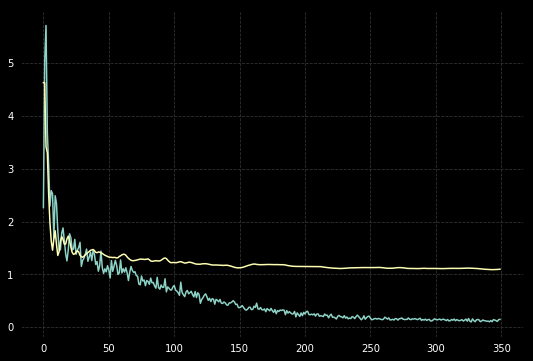

loading...
LightNN               3.229595


[{'result': 3.2295947090278387, 'core': <__main__.LightNN at 0x7f303b335390>}]

In [215]:
# mass_fit(X,Y_WT, LightNN(350,1000,activation='sigmoid',validation_data=train_test_split(X, Y_WT)[1::2]), scalerY=scalerY_WT)

## Selection AD

In [343]:
ens_AD = SelectEnsemble(X, Y_AD, scalerY=scalerY_AD)

In [344]:
ens_AD.fit([
    SelectModel(Lasso(0.006)), 
    SelectFunction(f_regression, 0.7), 
    SelectFunction(mutual_info_regression, 0.3),
    SelectTsfresh()
]);

Raw data...
train on 201, test on 201 rows x 4310 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.327339
Raw score: 2.327338587064677 

SelectModel...


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train on 201, test on 201 rows x 1213 columns
RandomForestRegressor 2.327682
quality: 0.9998525298113741
features selected: 1213 

SelectFunction...


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train on 201, test on 201 rows x 714 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.365972
quality: 0.9836713539711869
features selected: 714 

SelectFunction...


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train on 201, test on 201 rows x 423 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.423108
quality: 0.960476779963581
features selected: 423 

SelectTsfresh...
train on 201, test on 201 rows x 1028 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.280338
quality: 1.0206112415001691
features selected: 1028 



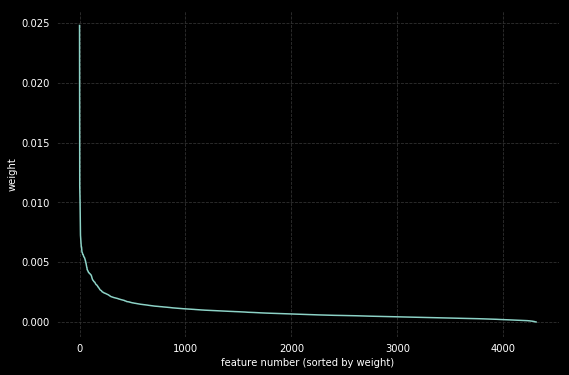

In [346]:
plt.plot(ens_AD.FI.sort_values(ascending=False).values)
plt.ylabel('weight')
plt.xlabel('feature number (sorted by weight)');

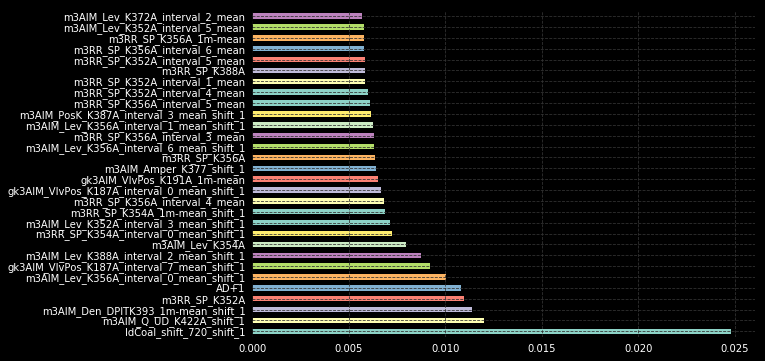

In [350]:
ens_AD.FI.sort_values(ascending=False)[:30].plot.barh()

In [360]:
selected_features_AD = ens_AD.select_features(0.1)

train on 201, test on 201 rows x 60 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.112653
0.1 : 60 2.112653074626865


## Selection WT

In [240]:
ens_WT = SelectEnsemble(X, Y_WT, scalerY=scalerY_WT)

In [241]:
ens_WT.fit([
    SelectModel(Lasso(0.006)), 
    SelectFunction(f_regression, 0.5), 
    SelectFunction(mutual_info_regression, 0.9),
    SelectTsfresh()
]);

Raw data...
train on 201, test on 201 rows x 4310 columns
XGBRegressor          3.033637
XGBRegressor          3.014135
XGBRegressor          3.200237
XGBRegressor          3.303395
Raw score: 3.0141347305262434 

SelectModel...
train on 201, test on 201 rows x 2 columns
XGBRegressor          3.117056
XGBRegressor          3.219343
XGBRegressor          3.430196
XGBRegressor          3.661528
quality: 0.9669811798976854
features selected: 2 

SelectFunction...
train on 201, test on 201 rows x 622 columns
XGBRegressor          2.762170
XGBRegressor          2.881606
XGBRegressor          2.804051
XGBRegressor          2.897028
quality: 1.0912200238927723
features selected: 622 

SelectFunction...
train on 201, test on 201 rows x 1630 columns
XGBRegressor          2.962460
XGBRegressor          3.018426
XGBRegressor          3.127812
XGBRegressor          3.561132
quality: 1.0174431559901198
features selected: 1630 

SelectTsfresh...
train on 201, test on 201 rows x 1 columns
XGBRegresso

Text(0.5,0,'feature number (sorted by weight)')

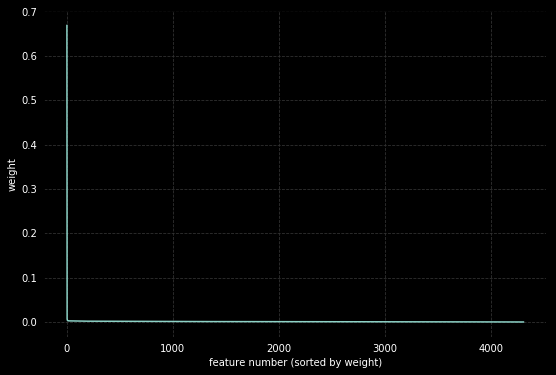

In [242]:
plt.plot(ens_WT.FI.sort_values(ascending=False).values)
plt.ylabel('weight');
plt.xlabel('feature number (sorted by weight)')

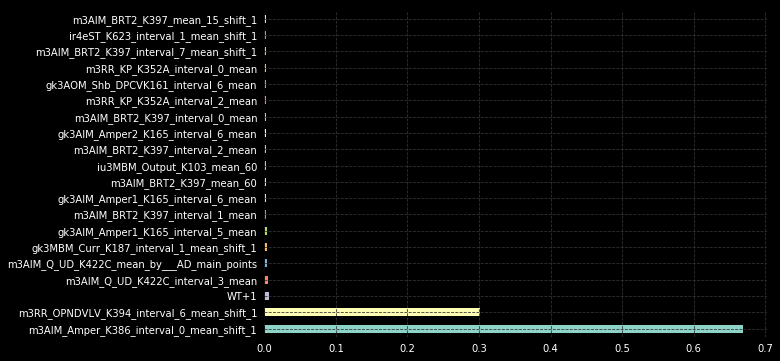

In [289]:
ens_WT.FI.sort_values(ascending=False)[:20].plot.barh()

In [259]:
selected_features_WT = ens_WT.select_features(0.25)

train on 201, test on 201 rows x 23 columns
XGBRegressor          2.727963
XGBRegressor          2.759735
XGBRegressor          2.936322
XGBRegressor          3.006880
0.25 : 23 2.727962765938477


# Predict AD

In [361]:
y = Y_AD
scaler = scalerY_AD

### RAW

In [365]:
feats = feats_all

x = X[feats]
validation_data = train_test_split(x, y)[1::2]

mass_fit(x, y, scalerY=scaler, models=
                   [
                       XGBRegressor(2, 0.1, 50),
                       LightNN(350, 1000, activation='sigmoid', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 4310 columns
XGBRegressor          2.367073
LightNN               4.020452


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.350580


### Selected

In [368]:
feats = selected_features_AD

x = X[feats]
validation_data = train_test_split(x, y)[1::2]

mass_fit(x, y, scalerY=scaler, models=
                   [
                       XGBRegressor(2, 0.1, 30),
                       LightNN(350, 1000, activation='tanh', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 60 columns
XGBRegressor          2.072067
LightNN               4.030576


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor 2.143295


In [83]:
print('dummy AD:',mean_squared_error(dataset['AD'],dataset['AD+1']))

dummy AD: 2.251417910447761


# Predict WT

In [372]:
y = Y_WT
scaler = scalerY_WT

### RAW

In [373]:
feats = feats_all

x = X[feats]
validation_data = train_test_split(x, y)[1::2]

mass_fit(x, y, scalerY=scaler, models=
                   [
                       XGBRegressor(2, 0.07, 100),
                       LightNN(400, 1000, activation='sigmoid', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 4310 columns
XGBRegressor          3.340927
LightNN               2.942301
RandomForestRegressor 2.929242


### Selected

In [277]:
feats = selected_features_WT

x = X[feats]
validation_data = train_test_split(x, y)[1::2]

mass_fit(x, y, scalerY=scaler, models=
                   [
                       XGBRegressor(2, 0.07, 100),
                       LightNN(350, 1000, activation='sigmoid', validation_data=validation_data, verbose=0),
                       RandomForestRegressor(100)
                   ]);

train on 201, test on 201 rows x 23 columns
XGBRegressor          2.818654
LightNN               2.779890
RandomForestRegressor 2.834111


In [82]:
print('dummy WT:',mean_squared_error(dataset['WT'],dataset['WT+1']))

dummy WT: 4.320149253731343


# NN test

## AD

In [50]:
targ = 'AD'
feats = selected_features_AD

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [51]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(1)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.0006, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=350, batch_size=1000, shuffle=False)

Epoch 1/350
201/201 [==============================] - 1s 3ms/step - loss: 63.0545 - mean_squared_error: 63.0545
Epoch 2/350
201/201 [==============================] - 0s 108us/step - loss: 13.3720 - mean_squared_error: 13.3720
Epoch 3/350
201/201 [==============================] - 0s 107us/step - loss: 8.5906 - mean_squared_error: 8.5906
Epoch 4/350
201/201 [==============================] - 0s 111us/step - loss: 7.0869 - mean_squared_error: 7.0869
Epoch 5/350
201/201 [==============================] - 0s 115us/step - loss: 8.3466 - mean_squared_error: 8.3466
Epoch 6/350
201/201 [==============================] - 0s 133us/step - loss: 6.6165 - mean_squared_error: 6.6165
Epoch 7/350
201/201 [==============================] - 0s 137us/step - loss: 6.3639 - mean_squared_error: 6.3639
Epoch 8/350
201/201 [==============================] - 0s 109us/step - loss: 6.4553 - mean_squared_error: 6.4553
Epoch 9/350
201/201 [==============================] - 0s 136us/step - loss: 6.0079 - mean_squ

Epoch 73/350
201/201 [==============================] - 0s 115us/step - loss: 5.6771 - mean_squared_error: 5.6771
Epoch 74/350
201/201 [==============================] - 0s 113us/step - loss: 6.1955 - mean_squared_error: 6.1955
Epoch 75/350
201/201 [==============================] - 0s 111us/step - loss: 6.6789 - mean_squared_error: 6.6789
Epoch 76/350
201/201 [==============================] - 0s 101us/step - loss: 7.0321 - mean_squared_error: 7.0321
Epoch 77/350
201/201 [==============================] - 0s 109us/step - loss: 6.0525 - mean_squared_error: 6.0525
Epoch 78/350
201/201 [==============================] - 0s 123us/step - loss: 6.7598 - mean_squared_error: 6.7598
Epoch 79/350
201/201 [==============================] - 0s 114us/step - loss: 5.7985 - mean_squared_error: 5.7985
Epoch 80/350
201/201 [==============================] - 0s 120us/step - loss: 6.1368 - mean_squared_error: 6.1368
Epoch 81/350
201/201 [==============================] - 0s 115us/step - loss: 6.4936 - m

Epoch 145/350
201/201 [==============================] - 0s 106us/step - loss: 6.0943 - mean_squared_error: 6.0943
Epoch 146/350
201/201 [==============================] - 0s 118us/step - loss: 6.2841 - mean_squared_error: 6.2841
Epoch 147/350
201/201 [==============================] - 0s 104us/step - loss: 5.9614 - mean_squared_error: 5.9614
Epoch 148/350
201/201 [==============================] - 0s 107us/step - loss: 6.3988 - mean_squared_error: 6.3988
Epoch 149/350
201/201 [==============================] - 0s 109us/step - loss: 6.3462 - mean_squared_error: 6.3462
Epoch 150/350
201/201 [==============================] - 0s 111us/step - loss: 5.8060 - mean_squared_error: 5.8060
Epoch 151/350
201/201 [==============================] - 0s 100us/step - loss: 5.6834 - mean_squared_error: 5.6834
Epoch 152/350
201/201 [==============================] - 0s 93us/step - loss: 5.9938 - mean_squared_error: 5.9938
Epoch 153/350
201/201 [==============================] - 0s 98us/step - loss: 6.1

Epoch 217/350
201/201 [==============================] - 0s 109us/step - loss: 5.6748 - mean_squared_error: 5.6748
Epoch 218/350
201/201 [==============================] - 0s 114us/step - loss: 6.4228 - mean_squared_error: 6.4228
Epoch 219/350
201/201 [==============================] - 0s 128us/step - loss: 5.9091 - mean_squared_error: 5.9091
Epoch 220/350
201/201 [==============================] - 0s 105us/step - loss: 5.6805 - mean_squared_error: 5.6805
Epoch 221/350
201/201 [==============================] - 0s 110us/step - loss: 6.3361 - mean_squared_error: 6.3361
Epoch 222/350
201/201 [==============================] - 0s 113us/step - loss: 5.8622 - mean_squared_error: 5.8622
Epoch 223/350
201/201 [==============================] - 0s 106us/step - loss: 6.1664 - mean_squared_error: 6.1664
Epoch 224/350
201/201 [==============================] - 0s 126us/step - loss: 6.3733 - mean_squared_error: 6.3733
Epoch 225/350
201/201 [==============================] - 0s 136us/step - loss: 6

Epoch 289/350
201/201 [==============================] - 0s 113us/step - loss: 5.6442 - mean_squared_error: 5.6442
Epoch 290/350
201/201 [==============================] - 0s 115us/step - loss: 5.9949 - mean_squared_error: 5.9949
Epoch 291/350
201/201 [==============================] - 0s 112us/step - loss: 6.5046 - mean_squared_error: 6.5046
Epoch 292/350
201/201 [==============================] - 0s 105us/step - loss: 5.8892 - mean_squared_error: 5.8892
Epoch 293/350
201/201 [==============================] - 0s 108us/step - loss: 5.6946 - mean_squared_error: 5.6946
Epoch 294/350
201/201 [==============================] - 0s 104us/step - loss: 4.8651 - mean_squared_error: 4.8651
Epoch 295/350
201/201 [==============================] - 0s 121us/step - loss: 5.5569 - mean_squared_error: 5.5569
Epoch 296/350
201/201 [==============================] - 0s 138us/step - loss: 5.2509 - mean_squared_error: 5.2509
Epoch 297/350
201/201 [==============================] - 0s 124us/step - loss: 4

In [52]:
p = neural.predict(X_test, len(X))*scale_mean[targ]['scale']+scale_mean[targ]['mean']
_test = y_test*scale_mean[targ]['scale']+scale_mean[targ]['mean']

result_AD = mean_squared_error(p,_test)
result_AD

3.910935452184633

## WT

In [171]:
targ = 'WT'
feats = selected_features_WT

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [172]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(1)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=250, batch_size=1000, shuffle=False)

Epoch 1/250
301/301 [==============================] - 2s 6ms/step - loss: 116.4929 - mean_squared_error: 116.4929
Epoch 2/250
301/301 [==============================] - 0s 19us/step - loss: 80.8007 - mean_squared_error: 80.8007
Epoch 3/250
301/301 [==============================] - 0s 22us/step - loss: 55.6509 - mean_squared_error: 55.6509
Epoch 4/250
301/301 [==============================] - 0s 18us/step - loss: 42.1868 - mean_squared_error: 42.1868
Epoch 5/250
301/301 [==============================] - 0s 23us/step - loss: 33.1816 - mean_squared_error: 33.1816
Epoch 6/250
301/301 [==============================] - 0s 21us/step - loss: 27.5976 - mean_squared_error: 27.5976
Epoch 7/250
301/301 [==============================] - 0s 24us/step - loss: 24.8995 - mean_squared_error: 24.8995
Epoch 8/250
301/301 [==============================] - 0s 21us/step - loss: 23.8910 - mean_squared_error: 23.8910
Epoch 9/250
301/301 [==============================] - 0s 23us/step - loss: 20.9660 - m

Epoch 74/250
301/301 [==============================] - 0s 17us/step - loss: 4.9562 - mean_squared_error: 4.9562
Epoch 75/250
301/301 [==============================] - 0s 21us/step - loss: 5.0796 - mean_squared_error: 5.0796
Epoch 76/250
301/301 [==============================] - 0s 19us/step - loss: 5.1657 - mean_squared_error: 5.1657
Epoch 77/250
301/301 [==============================] - 0s 23us/step - loss: 5.1345 - mean_squared_error: 5.1345
Epoch 78/250
301/301 [==============================] - 0s 19us/step - loss: 5.3822 - mean_squared_error: 5.3822
Epoch 79/250
301/301 [==============================] - 0s 17us/step - loss: 5.1846 - mean_squared_error: 5.1846
Epoch 80/250
301/301 [==============================] - 0s 19us/step - loss: 4.6594 - mean_squared_error: 4.6594
Epoch 81/250
301/301 [==============================] - 0s 22us/step - loss: 4.6275 - mean_squared_error: 4.6275
Epoch 82/250
301/301 [==============================] - 0s 22us/step - loss: 5.8318 - mean_squar

301/301 [==============================] - 0s 25us/step - loss: 5.3098 - mean_squared_error: 5.3098
Epoch 147/250
301/301 [==============================] - 0s 27us/step - loss: 5.0016 - mean_squared_error: 5.0016
Epoch 148/250
301/301 [==============================] - 0s 20us/step - loss: 4.3851 - mean_squared_error: 4.3851
Epoch 149/250
301/301 [==============================] - 0s 27us/step - loss: 5.1918 - mean_squared_error: 5.1918
Epoch 150/250
301/301 [==============================] - 0s 19us/step - loss: 4.2027 - mean_squared_error: 4.2027
Epoch 151/250
301/301 [==============================] - 0s 22us/step - loss: 5.5856 - mean_squared_error: 5.5856
Epoch 152/250
301/301 [==============================] - 0s 20us/step - loss: 4.5520 - mean_squared_error: 4.5520
Epoch 153/250
301/301 [==============================] - 0s 24us/step - loss: 5.1873 - mean_squared_error: 5.1873
Epoch 154/250
301/301 [==============================] - 0s 20us/step - loss: 4.7842 - mean_squared_er

Epoch 218/250
301/301 [==============================] - 0s 25us/step - loss: 4.6822 - mean_squared_error: 4.6822
Epoch 219/250
301/301 [==============================] - 0s 18us/step - loss: 4.9429 - mean_squared_error: 4.9429
Epoch 220/250
301/301 [==============================] - 0s 23us/step - loss: 5.0054 - mean_squared_error: 5.0054
Epoch 221/250
301/301 [==============================] - 0s 22us/step - loss: 5.0399 - mean_squared_error: 5.0399
Epoch 222/250
301/301 [==============================] - 0s 24us/step - loss: 5.5863 - mean_squared_error: 5.5863
Epoch 223/250
301/301 [==============================] - 0s 26us/step - loss: 5.1722 - mean_squared_error: 5.1722
Epoch 224/250
301/301 [==============================] - 0s 26us/step - loss: 5.3322 - mean_squared_error: 5.3322
Epoch 225/250
301/301 [==============================] - 0s 21us/step - loss: 4.9763 - mean_squared_error: 4.9763
Epoch 226/250
301/301 [==============================] - 0s 28us/step - loss: 4.3324 - m

In [173]:
p = neural.predict(X_test, len(X))*scale_mean[targ]['scale']+scale_mean[targ]['mean']
_test = y_test*scale_mean[targ]['scale']+scale_mean[targ]['mean']

result_WT = mean_squared_error(p,_test)
result_WT

3.55012574663479

## MultiTarget

In [174]:
selected_features_multi = list(selected_features_AD) + list(selected_features_WT)

In [175]:
targ = ['AD','WT']
feats = selected_features_multi

X_train, X_test, y_train, y_test = train_test_split(X[feats], Y[targ], shuffle=False)

n_feats = len(feats)

In [176]:
inputs = Input((n_feats,))
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.5)(x)
x = Dense(2)(x)
neural = Model(inputs=inputs, outputs=x)

neural.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])

neural.fit(X_train, y_train, epochs=450, batch_size=1000, shuffle=False)

Epoch 1/450
301/301 [==============================] - 2s 6ms/step - loss: 99.9708 - mean_squared_error: 99.9708
Epoch 2/450
301/301 [==============================] - 0s 29us/step - loss: 53.4918 - mean_squared_error: 53.4918
Epoch 3/450
301/301 [==============================] - 0s 30us/step - loss: 39.8632 - mean_squared_error: 39.8632
Epoch 4/450
301/301 [==============================] - 0s 30us/step - loss: 34.1488 - mean_squared_error: 34.1488
Epoch 5/450
301/301 [==============================] - 0s 26us/step - loss: 29.5237 - mean_squared_error: 29.5237
Epoch 6/450
301/301 [==============================] - 0s 34us/step - loss: 28.5566 - mean_squared_error: 28.5566
Epoch 7/450
301/301 [==============================] - 0s 30us/step - loss: 25.2301 - mean_squared_error: 25.2301
Epoch 8/450
301/301 [==============================] - 0s 27us/step - loss: 23.7388 - mean_squared_error: 23.7388
Epoch 9/450
301/301 [==============================] - 0s 29us/step - loss: 22.5738 - mea

Epoch 74/450
301/301 [==============================] - 0s 29us/step - loss: 5.8561 - mean_squared_error: 5.8561
Epoch 75/450
301/301 [==============================] - 0s 30us/step - loss: 5.5832 - mean_squared_error: 5.5832
Epoch 76/450
301/301 [==============================] - 0s 27us/step - loss: 5.7692 - mean_squared_error: 5.7692
Epoch 77/450
301/301 [==============================] - 0s 30us/step - loss: 5.8547 - mean_squared_error: 5.8547
Epoch 78/450
301/301 [==============================] - 0s 30us/step - loss: 6.1903 - mean_squared_error: 6.1903
Epoch 79/450
301/301 [==============================] - 0s 25us/step - loss: 5.8927 - mean_squared_error: 5.8927
Epoch 80/450
301/301 [==============================] - 0s 24us/step - loss: 6.0277 - mean_squared_error: 6.0277
Epoch 81/450
301/301 [==============================] - 0s 24us/step - loss: 6.2317 - mean_squared_error: 6.2317
Epoch 82/450
301/301 [==============================] - 0s 27us/step - loss: 6.0108 - mean_squar

301/301 [==============================] - 0s 27us/step - loss: 5.6687 - mean_squared_error: 5.6687
Epoch 147/450
301/301 [==============================] - 0s 25us/step - loss: 6.4250 - mean_squared_error: 6.4250
Epoch 148/450
301/301 [==============================] - 0s 39us/step - loss: 5.8432 - mean_squared_error: 5.8432
Epoch 149/450
301/301 [==============================] - 0s 25us/step - loss: 5.5223 - mean_squared_error: 5.5223
Epoch 150/450
301/301 [==============================] - 0s 31us/step - loss: 6.1824 - mean_squared_error: 6.1824
Epoch 151/450
301/301 [==============================] - 0s 34us/step - loss: 6.1621 - mean_squared_error: 6.1621
Epoch 152/450
301/301 [==============================] - 0s 26us/step - loss: 6.2125 - mean_squared_error: 6.2125
Epoch 153/450
301/301 [==============================] - 0s 30us/step - loss: 5.9201 - mean_squared_error: 5.9201
Epoch 154/450
301/301 [==============================] - 0s 33us/step - loss: 5.6250 - mean_squared_er

Epoch 218/450
301/301 [==============================] - 0s 28us/step - loss: 5.6575 - mean_squared_error: 5.6575
Epoch 219/450
301/301 [==============================] - 0s 30us/step - loss: 5.2321 - mean_squared_error: 5.2321
Epoch 220/450
301/301 [==============================] - 0s 32us/step - loss: 5.7536 - mean_squared_error: 5.7536
Epoch 221/450
301/301 [==============================] - 0s 27us/step - loss: 5.6024 - mean_squared_error: 5.6024
Epoch 222/450
301/301 [==============================] - 0s 44us/step - loss: 6.1860 - mean_squared_error: 6.1860
Epoch 223/450
301/301 [==============================] - 0s 27us/step - loss: 6.2770 - mean_squared_error: 6.2770
Epoch 224/450
301/301 [==============================] - 0s 25us/step - loss: 5.9374 - mean_squared_error: 5.9374
Epoch 225/450
301/301 [==============================] - 0s 27us/step - loss: 5.4930 - mean_squared_error: 5.4930
Epoch 226/450
301/301 [==============================] - 0s 26us/step - loss: 6.2316 - m

Epoch 290/450
301/301 [==============================] - 0s 26us/step - loss: 5.3257 - mean_squared_error: 5.3257
Epoch 291/450
301/301 [==============================] - 0s 26us/step - loss: 5.9315 - mean_squared_error: 5.9315
Epoch 292/450
301/301 [==============================] - 0s 31us/step - loss: 5.5493 - mean_squared_error: 5.5493
Epoch 293/450
301/301 [==============================] - 0s 27us/step - loss: 5.4263 - mean_squared_error: 5.4263
Epoch 294/450
301/301 [==============================] - 0s 30us/step - loss: 5.6487 - mean_squared_error: 5.6487
Epoch 295/450
301/301 [==============================] - 0s 33us/step - loss: 5.6385 - mean_squared_error: 5.6385
Epoch 296/450
301/301 [==============================] - 0s 27us/step - loss: 5.5944 - mean_squared_error: 5.5944
Epoch 297/450
301/301 [==============================] - 0s 29us/step - loss: 5.3450 - mean_squared_error: 5.3450
Epoch 298/450
301/301 [==============================] - 0s 31us/step - loss: 5.3465 - m

Epoch 362/450
301/301 [==============================] - 0s 30us/step - loss: 5.1313 - mean_squared_error: 5.1313
Epoch 363/450
301/301 [==============================] - 0s 28us/step - loss: 4.8618 - mean_squared_error: 4.8618
Epoch 364/450
301/301 [==============================] - 0s 27us/step - loss: 5.3344 - mean_squared_error: 5.3344
Epoch 365/450
301/301 [==============================] - 0s 28us/step - loss: 5.1208 - mean_squared_error: 5.1208
Epoch 366/450
301/301 [==============================] - 0s 32us/step - loss: 5.4218 - mean_squared_error: 5.4218
Epoch 367/450
301/301 [==============================] - 0s 25us/step - loss: 5.4591 - mean_squared_error: 5.4591
Epoch 368/450
301/301 [==============================] - 0s 31us/step - loss: 5.5251 - mean_squared_error: 5.5251
Epoch 369/450
301/301 [==============================] - 0s 27us/step - loss: 5.2799 - mean_squared_error: 5.2799
Epoch 370/450
301/301 [==============================] - 0s 24us/step - loss: 5.7967 - m

Epoch 434/450
301/301 [==============================] - 0s 24us/step - loss: 5.2925 - mean_squared_error: 5.2925
Epoch 435/450
301/301 [==============================] - 0s 23us/step - loss: 5.0478 - mean_squared_error: 5.0478
Epoch 436/450
301/301 [==============================] - 0s 26us/step - loss: 5.1755 - mean_squared_error: 5.1755
Epoch 437/450
301/301 [==============================] - 0s 26us/step - loss: 5.6871 - mean_squared_error: 5.6871
Epoch 438/450
301/301 [==============================] - 0s 27us/step - loss: 5.3191 - mean_squared_error: 5.3191
Epoch 439/450
301/301 [==============================] - 0s 23us/step - loss: 4.9078 - mean_squared_error: 4.9078
Epoch 440/450
301/301 [==============================] - 0s 19us/step - loss: 4.9944 - mean_squared_error: 4.9944
Epoch 441/450
301/301 [==============================] - 0s 27us/step - loss: 5.3805 - mean_squared_error: 5.3805
Epoch 442/450
301/301 [==============================] - 0s 27us/step - loss: 4.9165 - m

In [177]:
p = neural.predict(X_test, len(X))*scale_mean.loc['scale'].values + scale_mean.loc['mean'].values
_test = y_test*scale_mean.loc['scale'].values + scale_mean.loc['mean'].values

result_multi = mean_squared_error(p,_test)
result_multi

2.211659016921484